In [1]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
from google.colab import files
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/datasets/date_csv/basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) #Загружаем данные с google диска и создаем dataframe
print(df.shape)
df.head(10)

(52450, 9)


,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
0,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,0.0,1,1.0,30,81,90.0
1,"100,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,1,1.0,45,81,105.0
2,"99,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,0,81,120.0
3,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,30,81,150.0
4,"95,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,3,3.0,0,81,180.0
5,"91,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,4,4.0,0,81,240.0
6,"93,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,4,4.0,4,4.0,30,81,270.0
7,"90,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,4,4.0,6,6.0,0,81,360.0
8,"91,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,5,4.0,6,6.0,0,81,360.0
9,"92,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,5,5.0,6,6.0,0,81,360.0


In [13]:
#Выбираем часть датафрейма под тестовую выборку(20%)
df_test = df.iloc[::5,:]

In [14]:
#Из общего датафрейма исключаем тестовую, остается обучающая выборка
df_train = df[~df.index.isin(df_test.index)] 

In [15]:
XTrainInfo = (df_train['info']) #Обучающая выборка текстовых данных
XTestInfo = (df_test['info']) #Тестовая выборка текстовых данных

In [16]:
x_train = np.array(df_train[['Ком. 1', 'Ком. 2', 'ftime']].astype('int')) #Обучающая выборка числовых данных
y_train = np.array(df_train['fcount'].astype('int')) #Результат (количество очков) обучающей выборки

In [17]:
y_test = np.array(df_test['fcount'].astype('int')) #Результат (количество очков) тестовой выборки

In [18]:
#Нормируем данные обучающей выборки
team1_train = preprocessing.scale(df_train['Ком. 1'])
team2_train = preprocessing.scale(df_train['Ком. 2'])
time_train = preprocessing.scale(df_train['ftime'])

In [19]:
#Создаем обучающую выборку из нормированных данных
x1_train = np.hstack((team1_train.reshape(-1,1), team2_train.reshape(-1,1), time_train.reshape(-1,1)))

In [20]:
#Нормируем данные тестовой выборки
team1_test = preprocessing.scale(df_test['Ком. 1'])
team2_test = preprocessing.scale(df_test['Ком. 2'])
time_test = preprocessing.scale(df_test['ftime'])

In [22]:
#Создаем тестовую выборку из нормированных данных
x1_test = np.hstack((team1_test.reshape(-1,1), team2_test.reshape(-1,1), time_test.reshape(-1,1)))

In [23]:
#Нормируем выход сети - результат игры
yScaler = StandardScaler() #Делаем нормировщик с нормальным распределением
yScaler.fit(y_train.reshape(-1,1)) #Обучаем на результатах игры (на обучающей выборке)
y1_train = yScaler.transform(y_train.reshape(-1,1)) #Нормируем результат игры

#Выводим размер и два примера для сравнения ненормированных данных и нормированных
print(y1_train.shape)
print(y_train[0])
print(y1_train[0])

(41960, 1)
81
[-2.8376027]


In [24]:
#Нормируем результат игры на тестовой выборке
y1_test = yScaler.transform(y_test.reshape(-1,1)) #Нормируем результат игры

In [27]:
#Преобразовываем текстовые данные в числовые/векторные

maxWordsCount = 100 #Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

tokenizer = Tokenizer(num_words=maxWordsCount, 
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', 
                      lower=True, 
                      split=' ', 
                      oov_token='unknown', 
                      char_level=False)

tokenizer.fit_on_texts(XTrainInfo) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра
print(len(items))

1531


In [28]:
#Переводим в индексы обучающую и тестовую выборки
XTrainInfoIndexes = tokenizer.texts_to_sequences(XTrainInfo)
XTestInfoIndexes = tokenizer.texts_to_sequences(XTestInfo)

In [29]:
#Преобразовываем обучающую выборку из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
x_train01 = tokenizer.sequences_to_matrix(XTrainInfoIndexes) #Подаем XTrainInfoIndexes в виде списка чтобы метод успешно сработал
print(x_train01.shape)                                       #Размер обучающей выборки, сформированной по Bag of Words
print(x_train01[500][0:20])   
print(len(x_train01[500]))

(41960, 100)
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
100


In [30]:
#Преобразовываем тестовую выборку из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
x_test01 = tokenizer.sequences_to_matrix(XTestInfoIndexes) #Подаем XTestInfoIndexes в виде списка чтобы метод успешно сработал
print(x_test01.shape)                                       #Размер обучающей выборки, сформированной по Bag of Words
print(x_test01[500][0:20])   
print(len(x_test01[500]))

(10490, 100)
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
100


In [31]:
def on_train_begin(logs):
  global losses
  global val_losses
  losses = []
  val_losses = []
  global start
  global mae
  global best_mae
  start = datetime.datetime.now()
  print("Время начала:",start)
  mae = 0
  best_mae = sys.maxsize

def on_epoch_begin(epoch,logs):
  global epoch_start
  epoch_start = datetime.datetime.now()
  print("Шаг обучения:",round(K.eval(model.optimizer.lr),5))

def on_epoch_end(epoch,logs):
  clear_output(wait=True)

  prediction = model.predict([xTrainScaled[valMask],xTrainC01[valMask]])
  prediction_inverse = yScaler.inverse_transform(prediction).flatten()
  y_inverse = yScaler.inverse_transform([yTrainScaled[valMask]]).flatten()
  delta = prediction_inverse - y_inverse
  absDelta = abs(delta)
  print("Эпоха: ",epoch,", ","реальный модуль ошибки: ",round(sum(absDelta) / (1e+6 * len(absDelta)),3),sep="")

  losses.append(list(logs.values())[0])
  val_losses.append(list(logs.values())[1])
  if (len(losses) > 1):
    n = np.arange(0,len(losses))
    plt.figure()
    plt.plot(n,losses,label="Средний модуль ошибки на обучающем наборе данных")
    plt.plot(n,val_losses,label="Средний модуль ошибки на проверочном наборе данных")
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Средний модуль ошибки")
    plt.legend()
    plt.show()

  yy = yTrainScaled[valMask]
  plt.scatter(yy,prediction)
  plt.xlabel("Правильные значения")
  plt.ylabel("Предсказания")
  plt.axis("equal")
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-1000,5000],[-1000,5000])
  plt.show()
  
  delta_1 = prediction - yy
  absDelta_1 = abs(delta_1)
  plt.hist(absDelta_1.flatten(),bins=np.linspace(0,0.5,25),ec="black")
  plt.xlabel("Средний модуль ошибки")
  plt.ylabel("Количество")
  plt.show()

  cur_time = datetime.datetime.now()
  train_time = cur_time - start
  epoch_time = cur_time - epoch_start
  avg_time = (train_time / (epoch + 1))
  left_epochs = (epochs - (epoch + 1))
  left_time = avg_time * left_epochs
  print("Время обучения на эпохе: ",epoch_time,", ","суммарное время обучения: ",train_time," ,","осталось до конца: ",left_time,sep="")

  if epoch > 3:
    if ((val_losses[epoch - 3] + val_losses[epoch - 2] + val_losses[epoch - 1] + val_losses[epoch]) > 1e-3):
        model.optimizer.lr.assign(K.eval(model.optimizer.lr) * 0.9)
        print('Шаг обучения был изменён по причине: "Пила"')
        print("Новый шаг обучения:",round(K.eval(model.optimizer.lr),5))
    if ((val_losses[epoch - 3] + val_losses[epoch - 2] + val_losses[epoch - 1] + val_losses[epoch]) < 1e-3):
      model.optimizer.lr.assign(K.eval(model.optimizer.lr) * 0.9)
      print('Шаг обучения был изменён по причине: "Плато"')
      print("Новый шаг обучения:",round(K.eval(model.optimizer.lr),5))

  best_mae = val_losses[0]
  if (list(logs.values())[1] < best_mae):
    model.save_weights("best_mae.h5")
    best_mae = list(logs.values())[1]
    print("Значение весов обновлено, найдено лучшее значение")

In [35]:
def on_epoch_end_01(epoch, logs):
  pred_1 = model01_1.predict([x1_train[valMask], x_train01[valMask]]) #Получаем выход сети на проверочной выборке
  predUnscaled = yScaler.inverse_transform(pred_1).flatten() #Делаем обратное нормирование выхода к изначальным значениям результатов игры
  yTestUnscaled = yScaler.inverse_transform(y1_train[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым результатам
  delta = predUnscaled - yTestUnscaled #Считаем разность предсказанных и правильных результатов игр
  absDelta = abs(delta) #Берем модуль отклонения
  print('Эпоха', epoch, 'модуль ошибки', round(sum(absDelta) / len(absDelta),)) #Выводим усредненную ошибку, очков

#Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end_01)

In [36]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(x1_train.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

Эпоха 0 модуль ошибки 10.0
Эпоха 1 модуль ошибки 9.0
Эпоха 2 модуль ошибки 8.0
Эпоха 3 модуль ошибки 8.0
Эпоха 4 модуль ошибки 7.0
Эпоха 5 модуль ошибки 7.0
Эпоха 6 модуль ошибки 6.0
Эпоха 7 модуль ошибки 6.0
Эпоха 8 модуль ошибки 6.0
Эпоха 9 модуль ошибки 6.0
Эпоха 10 модуль ошибки 6.0
Эпоха 11 модуль ошибки 5.0
Эпоха 12 модуль ошибки 6.0
Эпоха 13 модуль ошибки 6.0
Эпоха 14 модуль ошибки 5.0
Эпоха 15 модуль ошибки 5.0
Эпоха 16 модуль ошибки 5.0
Эпоха 17 модуль ошибки 5.0
Эпоха 18 модуль ошибки 5.0
Эпоха 19 модуль ошибки 5.0
Эпоха 20 модуль ошибки 5.0
Эпоха 21 модуль ошибки 5.0
Эпоха 22 модуль ошибки 5.0
Эпоха 23 модуль ошибки 4.0
Эпоха 24 модуль ошибки 4.0
Эпоха 25 модуль ошибки 4.0
Эпоха 26 модуль ошибки 4.0
Эпоха 27 модуль ошибки 4.0
Эпоха 28 модуль ошибки 4.0
Эпоха 29 модуль ошибки 4.0
Эпоха 30 модуль ошибки 4.0
Эпоха 31 модуль ошибки 4.0
Эпоха 32 модуль ошибки 4.0
Эпоха 33 модуль ошибки 5.0
Эпоха 34 модуль ошибки 4.0
Эпоха 35 модуль ошибки 4.0
Эпоха 36 модуль ошибки 4.0
Эпоха 37 м

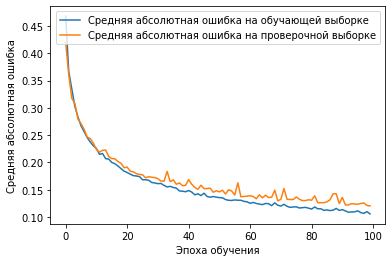

In [37]:
input1 = Input((x1_train.shape[1],))
input2 = Input((x_train01.shape[1],))

x1 = Dense(500, activation="relu")(input1)
x2 = Dense(50, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(200, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model01_1 = Model((input1, input2), x)

model01_1.compile(optimizer='adam', loss='mae')

history = model01_1.fit([x1_train[~valMask], x_train01[~valMask]], y1_train[~valMask],
                    epochs=100,
                    batch_size=700,
                    validation_data=([x1_train[valMask], x_train01[valMask]], y1_train[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

#Проверяем результаты, уже не на проверочной, а на тестовой выборке
pred = model01_1.predict([x1_test, x_test01]) #Получаем выход сети на тестовой выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным значениям результатов игры
# yTestUnscaled = yScaler.inverse_transform(y1_test).flatten() #Делаем такое же обратное нормирование yTest к базовым результатам
# delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных результатов
delta = predUnscaled - y_test
absDelta = abs(delta) #Берем модуль отклонения
print('модуль ошибки', round(sum(absDelta) / len(absDelta),)) #Выводим усредненную ошибку, очков

#Выводим графики ошибки
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающей выборке')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()